<a href="https://colab.research.google.com/github/aruaru0/HuBmap/blob/main/schedule_0_72_b5_train_segformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SegFormer Train

In [1]:
!nvidia-smi

Sat Sep  3 01:49:06 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%%capture
!pip install wandb --upgrade

In [4]:
!cp /content/drive/MyDrive/Kaggle/netrc ~/.netrc

In [5]:
import wandb
wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: aruaru0. Use `wandb login --relogin` to force relogin


True

## kaggle

In [6]:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/datas/kaggle.json  ~/.kaggle/

In [7]:
!chmod 600 /root/.kaggle/kaggle.json

In [8]:
!kaggle competitions download -c hubmap-organ-segmentation

100% 5.75G/5.78G [00:37<00:00, 249MB/s]
100% 5.78G/5.78G [00:37<00:00, 164MB/s]


In [9]:
# !mkdir hubmap
!unzip /content/hubmap-organ-segmentation.zip -d hubmap >/dev/null

In [10]:
!pip install pytorch-lightning
!pip install transformers datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 706 kB 7.6 MB/s 
     |████████████████████████████████| 5.9 MB 57.5 MB/s 
     |████████████████████████████████| 419 kB 56.1 MB/s 
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220719082949 requires tensorboard<2.9,>=2.8, but you have tensorboard 2.10.0 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 6.6 MB/s 
     |████████████████████████████████| 365 kB 68.5 MB/s 
     |████████████████████████████████| 

In [11]:
!pip install staintools
!pip install spams

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for staintools: filename=staintools-2.1.2-py3-none-any.whl size=14075 sha256=c780eb79b5d3827f4cb6f6e522fa24764c325c499a2c5380cff8336e644783b6
  Stored in directory: /root/.cache/pip/wheels/9b/ed/74/9d36d40854e911d8e2d2d28d7b67e37e9f176f913ecf34f813
Successfully built staintools
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 8.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for spams: filename=spams-2.6.5.4-cp37-cp37m-linux_x86_64.whl size=3236610 sha256=262a1c1464dd5ec209a2bdaa78f536541cfcc00dc287cb6c5185e97b64b8c4f9
  Stored in directory: /root/.cache/pip/wheels/5e/92/17/e718e0e26bfcdd7e81afcf874ac2bc599dd7dd7f3ad78f9d76
Successfully built spams


In [12]:
# from google.colab import output
# output.enable_custom_widget_manager()

## Start code

In [13]:
import wandb
wandb.init(project="HuBMAP-SegFormer")

In [14]:
%load_ext tensorboard

In [15]:
from google.colab import output
output.enable_custom_widget_manager()

In [16]:
from torch.utils.tensorboard import SummaryWriter

In [17]:
from typing import Optional, List

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ConstantLR, LinearLR
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import torchvision.transforms as transforms
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# from timm import create_model

import numpy as np
import cv2
import matplotlib.pyplot as plt

import os
import albumentations as albu
import random

import pandas as pd

from tqdm.notebook import tqdm

from sklearn.model_selection import KFold

In [18]:
#https://www.kaggle.com/code/pestipeti/decoding-rle-masks/notebook
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


def rle2mask(mask_rle, shape=(3000,3000)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0::2], s[1::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

##  load test data

In [19]:
SEED = 43
BATCH_SIZE = 4
Gradient_Accumulation_Step = 7

In [20]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    #the following line gives ~10% speedup
    #but may lead to some stochasticity in the results 
    torch.backends.cudnn.benchmark = True
    
seed_everything(SEED)

In [21]:
DATA_DIR = './hubmap'
NFOLD = 5
FOLD = 3

WIDTH, HEIGHT = 512,512

model_path = '/content/drive/MyDrive/datas/HuBMAP/model-b5-fold{}.pth'.format(FOLD)
MODEL_NAME = "nvidia/mit-b5"
# MODEL_NAME = "nvidia/segformer-b3-finetuned-ade-512-512"

wandb.SEED = SEED
wandb.config.NFOLD = NFOLD
wandb.config.FOLD = FOLD
wandb.config.WIDTH = WIDTH
wandb.config.HEIGHT= HEIGHT
wandb.config.MODEL_NAME = MODEL_NAME

#
# nvidia/segformer-b0-finetuned-ade-512-512
# nvidia/segformer-b1-finetuned-ade-512-512
# nvidia/segformer-b2-finetuned-ade-512-512
# nvidia/segformer-b3-finetuned-ade-512-512
# nvidia/segformer-b4-finetuned-ade-512-512
# nvidia/segformer-b5-finetuned-ade-640-640
# https://huggingface.co/models?other=segformer&sort=downloads&search=nvidia%2Fsegformer+finetuned
#
df = pd.read_csv(DATA_DIR + '/train.csv')

In [22]:
# df = df[df['organ']=='lung'].reset_index()
df

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female
...,...,...,...,...,...,...,...,...,...,...
346,9517,kidney,HPA,3000,3000,0.4,4,1611763 11 1614753 29 1617750 35 1620746 43 16...,61.0,Male
347,9769,kidney,HPA,3070,3070,0.4,4,4030400 28 4033466 34 4036526 48 4039594 54 40...,28.0,Male
348,9777,largeintestine,HPA,3000,3000,0.4,4,538473 13 541468 22 544463 30 547461 35 550459...,84.0,Male
349,9791,kidney,HPA,3000,3000,0.4,4,334733 33 337729 43 340729 43 343725 51 346723...,28.0,Male


In [23]:
# class2idx = dict([(name,i+1) for i, name in enumerate(df.organ.unique())])
# class2idx['none'] = 0
# idx2class = dict([(class2idx[name], name) for name in class2idx])

class2idx = {'prostate': 1,
  'spleen': 2,
  'lung': 3,
  'kidney': 4,
  'largeintestine': 5,
  'none': 0}
idx2class = {1: 'prostate',
  2: 'spleen',
  3: 'lung',
  4: 'kidney',
  5: 'largeintestine',
  0: 'none'}

class2idx, idx2class

({'prostate': 1,
  'spleen': 2,
  'lung': 3,
  'kidney': 4,
  'largeintestine': 5,
  'none': 0},
 {1: 'prostate',
  2: 'spleen',
  3: 'lung',
  4: 'kidney',
  5: 'largeintestine',
  0: 'none'})

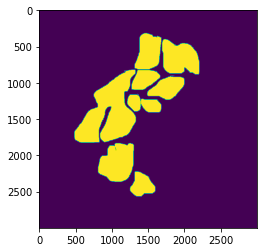

In [24]:
idx = 0
height, width, rle = df['img_height'][idx], df['img_width'][idx], df['rle'][idx]
mask = rle2mask(rle, shape=(height, width))
plt.imshow(mask)

In [25]:
from sklearn.model_selection import StratifiedKFold

df['fold'] = 0

skf = StratifiedKFold(n_splits=5)
for i, index in enumerate(skf.split(df.id, df.organ)):
  train_index, test_index = index
  # print("train_index:", train_index, "test_index:", test_index)
  # df['fold'][test_index] = i
  df.loc[test_index, 'fold'] = i

df

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex,fold
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male,0
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male,0
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male,0
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male,0
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female,0
...,...,...,...,...,...,...,...,...,...,...,...
346,9517,kidney,HPA,3000,3000,0.4,4,1611763 11 1614753 29 1617750 35 1620746 43 16...,61.0,Male,4
347,9769,kidney,HPA,3070,3070,0.4,4,4030400 28 4033466 34 4036526 48 4039594 54 40...,28.0,Male,4
348,9777,largeintestine,HPA,3000,3000,0.4,4,538473 13 541468 22 544463 30 547461 35 550459...,84.0,Male,4
349,9791,kidney,HPA,3000,3000,0.4,4,334733 33 337729 43 340729 43 343725 51 346723...,28.0,Male,4


## Utils

### augumentation

In [26]:
import staintools

In [27]:
class Stain(albu.ImageOnlyTransform):
    def __init__(
        self,
        method='vahadane', sigma1=0.2, sigma2=0.2,
        always_apply=False,
        p=0.5,
    ):
        super(Stain, self).__init__(always_apply, p)
        self.method = method
        self.sigma1 = sigma1
        self.sigma2 = sigma2
        self.augmentor = staintools.StainAugmentor(method=method, sigma1=sigma1, sigma2=sigma2)

    def apply(self, img, **params):
        self.augmentor.fit(img)
        return self.augmentor.pop().astype(int)

    def get_params(self):
        return {
        }

    def get_transform_init_args_names(self):
        return ("brightness_limit", "contrast_limit", "brightness_by_max")

In [28]:
# ----- set0
def get_training_augmentation_set0(p=0.5):
    return albu.Compose([
        albu.Sequential([
          albu.RandomScale(scale_limit=(-0.8, 0.0), interpolation=cv2.INTER_LINEAR, p=1),
          albu.Resize(HEIGHT, WIDTH, interpolation=cv2.INTER_LINEAR, p=1)
        ], p=p),
        albu.HorizontalFlip(p=p),
        albu.VerticalFlip(p=p),
        albu.RandomRotate90(p=p),
        albu.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=p, 
                         border_mode=cv2.BORDER_REFLECT),
        # albu.OneOf([
        #     albu.OpticalDistortion(p=1),
        #     albu.GridDistortion(p=1),
        #     albu.IAAPiecewiseAffine(p=1),
        # ], p=p),
        albu.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=p),
        albu.OneOf([
            albu.CLAHE(clip_limit=2, p = 1),
            albu.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.2, p=1),
            albu.HueSaturationValue (hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=1),
        ], p=p),
        albu.GaussNoise(var_limit=(10.0, 50.0), p=p),
    ], p=p)
# ---- set1
def get_training_augmentation_set1(p=0.5):
    return albu.Compose([
        albu.Sequential([
          albu.RandomScale(scale_limit=(-0.8, 0.0), interpolation=cv2.INTER_LINEAR, p=1),
          albu.Resize(HEIGHT, WIDTH, interpolation=cv2.INTER_LINEAR, p=1)
        ], p=p),
        albu.HorizontalFlip(p=p),
        albu.VerticalFlip(p=p),
        albu.RandomRotate90(p=p),
        # albu.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=p, 
        #                  border_mode=cv2.BORDER_REFLECT),
        albu.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=15, p=p, 
                         border_mode=cv2.BORDER_REFLECT),
        # albu.OneOf([
        #     albu.OpticalDistortion(p=1),
        #     albu.GridDistortion(p=1),
        #     albu.IAAPiecewiseAffine(p=1),
        # ], p=p),
        albu.ChannelShuffle(p=p),
        albu.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=p),
        albu.OneOf([
            albu.CLAHE(clip_limit=2, p = 1),
            albu.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.2, p=1),
            albu.HueSaturationValue (hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=1),
        ], p=p),
        albu.GaussNoise(var_limit=(10.0, 50.0), p=p),
    ], p=p)


In [29]:
def get_training_augmentation3(p=0.5):
    return albu.Compose([
        albu.Sequential([
          albu.RandomScale(scale_limit=(-0.8, 0.0), interpolation=cv2.INTER_LINEAR, p=1),
          albu.Resize(HEIGHT, WIDTH, interpolation=cv2.INTER_LINEAR, p=1)
        ], p=p),
        albu.HorizontalFlip(p=p),
        albu.VerticalFlip(p=p),
        albu.RandomRotate90(p=p),
        albu.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=p, 
                         border_mode=cv2.BORDER_REFLECT),
        # albu.OneOf([
        #     albu.OpticalDistortion(p=1),
        #     albu.GridDistortion(p=1),
        #     albu.IAAPiecewiseAffine(p=1),
        # ], p=p),
        albu.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=p),
        albu.OneOf([
            # albu.CLAHE(clip_limit=2, p = 1),
            albu.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.2, p=1),
            albu.HueSaturationValue (hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=1),
        ], p=p),
        albu.GaussNoise(var_limit=(10.0, 50.0), p=p),
        # albu.CoarseDropout (max_holes=50, max_height=16, max_width=16, p=p)
    ], p=p)

# def get_training_augmentation3(p=0.5):
#     return albu.Compose([
#         albu.Sequential([
#           albu.RandomScale(scale_limit=(-0.8, 0.0), interpolation=cv2.INTER_LINEAR, p=1),
#           albu.Resize(HEIGHT, WIDTH, interpolation=cv2.INTER_LINEAR, p=1)
#         ], p=p),
#         albu.HorizontalFlip(p=p),
#         albu.VerticalFlip(p=p),
#         albu.RandomRotate90(p=p),
#         albu.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=p, 
#                          border_mode=cv2.BORDER_REFLECT),
#         # albu.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=15, p=p, 
#         #                  border_mode=cv2.BORDER_REFLECT),
#         # albu.OneOf([
#         #     albu.OpticalDistortion(p=1),
#         #     albu.GridDistortion(p=1),
#         #     albu.IAAPiecewiseAffine(p=1),
#         # ], p=p),
#         albu.OneOf([
#             albu.ChannelShuffle(p=1),
#             albu.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=1),
#             albu.CLAHE(clip_limit=2, p = 1),
#             albu.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.2, p=1),
#             albu.HueSaturationValue (hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=1),
#         ], p=p),
#         albu.GaussNoise(var_limit=(10.0, 50.0), p=p),
#         albu.CoarseDropout (max_holes=50, max_height=16, max_width=16, p=p)
#     ], p=p)


In [30]:
def get_training_augmentation2(p=1.0):
    return albu.Compose([
        albu.HorizontalFlip(),
        albu.VerticalFlip(),
        albu.RandomRotate90(),
        albu.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.9, 
                         border_mode=cv2.BORDER_REFLECT),
        albu.OneOf([
            albu.OpticalDistortion(p=0.3),
            albu.GridDistortion(p=.1),
            albu.IAAPiecewiseAffine(p=0.3),
        ], p=0.3),
        albu.OneOf([
            # albu.HueSaturationValue(10,15,10),
            albu.CLAHE(clip_limit=2),
            albu.RandomBrightnessContrast(),            
        ], p=0.3),
        albu.GaussNoise(var_limit=(10.0, 50.0), p=0.3)
    ], p=p)

def get_training_augmentation():
    train_transform = [
        albu.PadIfNeeded(min_height=HEIGHT, min_width=WIDTH, always_apply=True, border_mode=0),
        albu.RandomCrop(height=HEIGHT, width=WIDTH, always_apply=True),
    ]
    return albu.Compose(train_transform)


def get_grayaug():
    train_transform = [
        albu.ToGray(p=1.0),
    ]
    return albu.Compose(train_transform)

# def get_validation_augmentation():
#     """画像のshapeが32で割り切れるようにPaddingするための関数"""
#     test_transform = [
#         albu.PadIfNeeded(384, 480)
#     ]
#     return albu.Compose(test_transform)

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

# 可視化用の関数
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

## dataset

In [31]:
from transformers import SegformerFeatureExtractor

mean = np.array([0.7720342, 0.74582646, 0.76392896])
std = np.array([0.24745085, 0.26182273, 0.25782376])

def img2tensor(img,dtype:np.dtype=np.float32):
    if img.ndim==2 : img = np.expand_dims(img,2)
    img = np.transpose(img,(2,0,1))
    return torch.from_numpy(img.astype(dtype, copy=False))


# 1. torch.utils.data.Datasetを継承したDataset classを定義
class Dataset(torch.utils.data.Dataset):
    # CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
    #            'tree', 'signsymbol', 'fence', 'car', 
    #            'pedestrian', 'bicyclist', 'unlabelled']
    
    def __init__(
            self,
            image_dir, 
            df, # ファイル名一覧
            # classes=None, # 推論対象のクラス
            augmentation=None, # augmentation用関数
            preprocessing=None, # 前処理用関数
            width = 768,
            height = 768,
    ):
        self.image_dir = image_dir
        self.df = df
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.width = width
        self.height = height
        self.feature_extractor = SegformerFeatureExtractor(MODEL_NAME , reduce_labels=False, size=(width, height))
    
    # 3. 学習用データ(image)と特徴(mask)を返す__getitem__メソッドを作成
    def __getitem__(self, i):
        # データの読み込み
        fname = "{}/{}.tiff".format(self.image_dir,self.df['id'][i])
        # print(fname)
        image = cv2.imread(fname)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        rle, w, h = self.df['rle'][i], self.df['img_width'][i], self.df['img_height'][i]
        idx = class2idx[self.df['organ'][i]]
        mask = rle2mask(rle, shape = (w, h))
        # print(self.df['organ'][i], idx)

        image = cv2.resize(image, (self.width, self.height))
        mask = cv2.resize(mask, (self.width, self.height)) * idx

        # augmentation関数の適用
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # print("image", image.shape)
        # # return image, mask
        # image = (image/255 - mean)/std
        
        # return img2tensor(image),torch.tensor(mask), idx
        # return image, mask
        encoded_inputs = self.feature_extractor(image, mask, return_tensors="pt")

        for k,v in encoded_inputs.items():
          encoded_inputs[k].squeeze_() # remove batch dimension

        return encoded_inputs

    # 4. データセットの長さを返す__len__を作成
    def __len__(self):
        return len(self.df)

torch.Size([3, 512, 512])


tensor([0, 1])

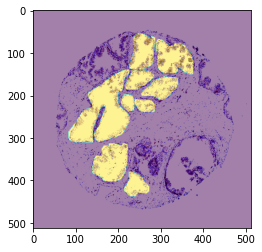

In [32]:
IMAGE_DIR = './hubmap/train_images'
train_dataset = Dataset(IMAGE_DIR, df[df['fold'] != FOLD].reset_index(), width=WIDTH, height=HEIGHT)
input = train_dataset[0]
print(input['pixel_values'].shape)
plt.imshow(input['pixel_values'].permute(1,2,0).numpy())
plt.imshow(input['labels'], alpha=0.5)
input['labels'].unique()

In [33]:
input

{'pixel_values': tensor([[[2.0777, 2.0777, 2.0605,  ..., 2.0777, 2.0777, 2.0777],
         [2.0777, 2.0777, 2.0777,  ..., 2.0777, 2.0777, 2.0777],
         [2.0263, 2.0777, 2.0777,  ..., 2.0777, 2.0777, 2.0777],
         ...,
         [2.0605, 2.0777, 2.0434,  ..., 2.0777, 2.0777, 2.0777],
         [2.0777, 2.0777, 2.0777,  ..., 2.0434, 2.0777, 2.0777],
         [2.0777, 2.0777, 2.0605,  ..., 2.0777, 2.0605, 2.0777]],

        [[2.2360, 2.2535, 2.2185,  ..., 2.2535, 2.2535, 2.2535],
         [2.2360, 2.2360, 2.2535,  ..., 2.2535, 2.2535, 2.2535],
         [2.2010, 2.2185, 2.2535,  ..., 2.2535, 2.2360, 2.2535],
         ...,
         [2.2535, 2.2360, 2.2360,  ..., 2.2535, 2.2535, 2.2535],
         [2.2535, 2.2360, 2.2535,  ..., 2.2535, 2.2360, 2.2535],
         [2.2360, 2.2535, 2.2360,  ..., 2.2360, 2.2360, 2.2535]],

        [[2.4657, 2.4657, 2.4483,  ..., 2.4657, 2.4657, 2.4657],
         [2.4657, 2.4657, 2.4657,  ..., 2.4657, 2.4483, 2.4657],
         [2.3786, 2.3960, 2.4483,  ..., 2

280


0 torch.Size([3, 512, 512])


0 torch.Size([3, 512, 512])


0 torch.Size([3, 512, 512])


0 torch.Size([3, 512, 512])


0 torch.Size([3, 512, 512])
0 torch.Size([3, 512, 512])


0 torch.Size([3, 512, 512])


0 torch.Size([3, 512, 512])


0 torch.Size([3, 512, 512])


0 torch.Size([3, 512, 512])


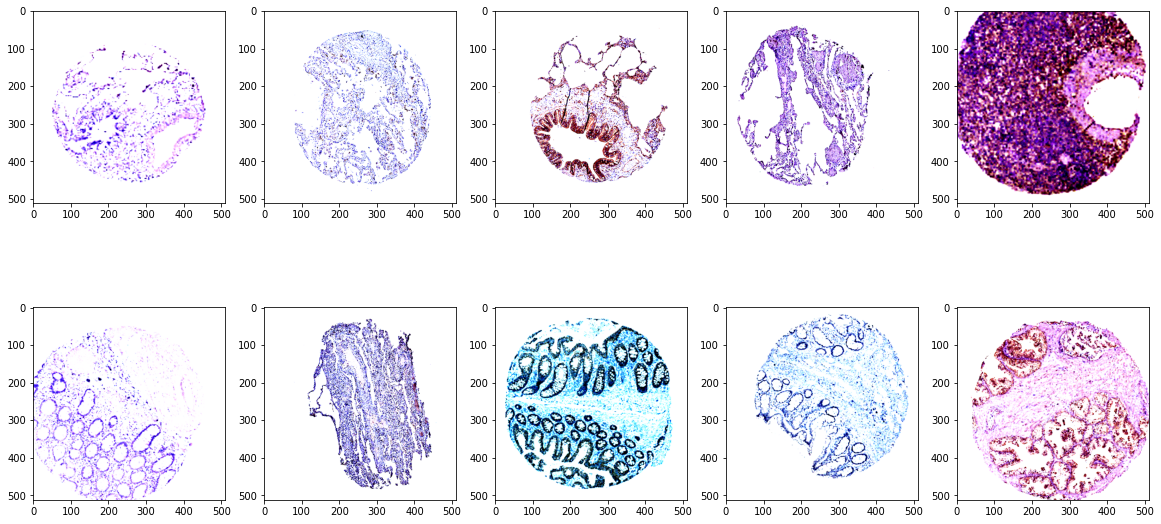

In [34]:
# # # データセットのインスタンスを作成
train_dataset = Dataset(IMAGE_DIR, df[df['fold'] != 0].reset_index(), 
                        width=WIDTH, height=HEIGHT,
                        augmentation=get_training_augmentation3(), 
                        )

plt.figure(figsize=(20, 10))

print(train_dataset.__len__())
for i in range(10) :
  input = train_dataset[i]
  print(idx, input.pixel_values.shape)
  plt.subplot(2, 5, i+1);
  plt.imshow(input['pixel_values'].permute(1,2,0).numpy())
  # plt.imshow(input['labels'], alpha=0.5)
plt.show()

In [35]:
from torch.utils.data import DataLoader
# CLASSES = ['car']


# データセットのインスタンスを作成
train_dataset = Dataset(IMAGE_DIR, df[df['fold'] != FOLD].reset_index(), 
                        width=WIDTH, height=HEIGHT,
                        augmentation=get_training_augmentation3(p=0.9), 
                        )
# train_dataset = Dataset(IMAGE_DIR, df.reset_index(), 
#                         width=WIDTH, height=HEIGHT,
#                         augmentation=get_training_augmentation3(p=0.9), 
#                         )

valid_dataset = Dataset(
    IMAGE_DIR, df[df['fold'] == FOLD].reset_index(), 
    width=WIDTH, height=HEIGHT,
    augmentation=None, 
)

# データローダーの作成
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

0


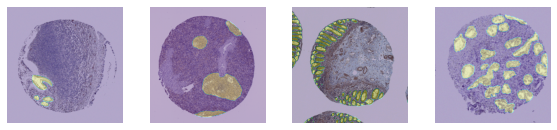

In [36]:
row, col = 8, 8
plt.figure(figsize=(20,20))

for inputs in train_loader:
  print(idx)
  data = inputs['pixel_values']
  mask = inputs['labels']
  for i in range(BATCH_SIZE) :
    plt.subplot(col, row, i+1)
    x = data[i].permute(1,2,0)
    plt.imshow((x-x.min())/(x.max()-x.min()))
    plt.imshow(mask[i], alpha=0.3)
    plt.axis('off')
  # print(data.shape)
  break

## ここまで前処理

In [37]:
from transformers import SegformerForSemanticSegmentation
# define model
model = SegformerForSemanticSegmentation.from_pretrained(MODEL_NAME,
                                                         num_labels=len(class2idx), 
                                                         id2label=idx2class, 
                                                         label2id=class2idx,
                                                         ignore_mismatched_sizes=True,
)

Some weights of the model checkpoint at nvidia/mit-b5 were not used when initializing SegformerForSemanticSegmentation: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b5 and are newly initialized: ['decode_head.linear_c.2.proj.weight', 'decode_head.batch_norm.running_mean', 'decode_head.linear_c.1.proj.weight', 'decode_head.classifier.weight', 'decode_head.linear_fuse.weight', 'decode_head.batc

In [38]:
# # model_path = '/content/drive/MyDrive/datas/HuBMAP/model.pth'
# model_path_last = '/content/drive/MyDrive/datas/HuBMAP/last-fold{}.pth'.format(FOLD)
# model.load_state_dict(torch.load(model_path_last))

In [39]:
from datasets import load_metric

metric = load_metric("mean_iou")

In [40]:
test_df = df[df['fold'] == FOLD].reset_index()

def dice_coef(mask1, mask2):
    intersect = np.sum(mask1*mask2)
    sum1 = np.sum(mask1)
    sum2 = np.sum(mask2)
    dice = 2*intersect/(sum1+sum2)
    dice = np.mean(dice)
    return dice

def valid(model2) :
  model2.eval()
  dice = 0.0
  loss = 0.0
  for i in tqdm(range(len(test_df))) :
    id = test_df.id[i]
    fname = "/content/hubmap/train_images/{}.tiff".format(id)
    image = Image.open(fname)
    encoding = feature_extractor(image, return_tensors="pt")
    pixel_values = encoding.pixel_values.cuda()

    # print(pixel_values.shape)

    organ = test_df.organ[i]
    idx = class2idx[organ]

    rle = test_df.rle[i]
    height, width = test_df.img_height[i], test_df.img_width[i]
    gt = rle2mask(rle, shape = (height, width))
    gt2 = cv2.resize(gt, pixel_values.shape[-2:]) * idx

    label = torch.tensor(gt2).unsqueeze(0).long().cuda()

    # print(label.shape)

    with torch.no_grad():
      outputs = model2(pixel_values=pixel_values, labels=label)
      loss += outputs.loss.item()
      # print(outputs.loss, loss)
      upsampled_logits = nn.functional.interpolate(outputs['logits'],
                  # size=image.size[::-1], # (height, width)
                  (height, width),
                  mode='bilinear',
                  align_corners=False)
      mask = upsampled_logits.argmax(dim=1)[0]
      mask[mask != idx] = 0
      mask[mask == idx] = 1


    dice += dice_coef(mask.cpu().numpy(), gt)
  return dice/len(test_df), loss/len(test_df)

In [41]:
# import torch
# from torch import nn
# from sklearn.metrics import accuracy_score
# # from tqdm.notebook import tqdm
# # from tqdm import tqdm
# from fastprogress.fastprogress import  progress_bar as tqdm

# from PIL import Image
# from transformers import SegformerFeatureExtractor

# feature_extractor = SegformerFeatureExtractor(reduce_labels=False, size=(WIDTH, HEIGHT))
# model = model.cuda()
# valid(model)

## TRAIN


In [ ]:
import torch
from torch import nn
from sklearn.metrics import accuracy_score
# from tqdm.notebook import tqdm
# from tqdm import tqdm
from fastprogress.fastprogress import  progress_bar as tqdm

from PIL import Image
from transformers import SegformerFeatureExtractor

writer = SummaryWriter(log_dir="./logs")
feature_extractor = SegformerFeatureExtractor(reduce_labels=False, size=(WIDTH, HEIGHT))
use_amp = True # ampをオンオフ


# define optimizer
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4,  weight_decay=1e-4)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 50, gamma=0.9)

# move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, 
                                              base_lr=1e-5,
                                              max_lr=1e-3,
                                              step_size_up=7,
                                              step_size_down=13,
                                              mode="triangular2",
                                              cycle_momentum=False,
                                              gamma=0.95)


model.train()
cur_loss = 0
best_epoch = 0
for epoch in range(300):  # loop over the dataset multiple times
   print("Epoch:", epoch)
   
   model.train()
   optimizer.zero_grad()

   tot_loss = 0.0
   for idx, batch in enumerate(tqdm(train_loader)):
        # get the inputs;
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        # print(pixel_values.shape, labels.shape)

        # zero the parameter gradients
        with torch.cuda.amp.autocast(enabled=use_amp):
            # forward + backward + optimize
            outputs = model(pixel_values=pixel_values, labels=labels)
            loss, logits = outputs.loss, outputs.logits

        tot_loss += loss.detach().cpu().numpy()
        
        scaler.scale(loss).backward()

        if (idx + 1) % Gradient_Accumulation_Step == 0 or idx == len(train_loader) :
            # optimizer.step()
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

   scheduler.step()

   print("Loss:", tot_loss/len(train_loader))

   print("valid...")
   dice,valid_loss = valid(model)

   writer.add_scalars("loss", {
       "train": tot_loss/len(train_loader),
       "valid": valid_loss,
       }, epoch+1)  
   writer.add_scalar("lr", scheduler.get_last_lr()[0], epoch+1)
   
   wandb.log({'epoch': epoch, 'train_loss': tot_loss/len(train_loader), "valid_loss": valid_loss, 
              "dice": dice, "lr":scheduler.get_last_lr()[0], "best dice": cur_loss, "best epoch": best_epoch})
   if dice > cur_loss :
     cur_loss = dice
     best_epoch = epoch
     print("update best dice = ", dice, "loss = ", valid_loss)
     torch.save(model.state_dict(), model_path)
   else :
     print("epoch dice = ", dice, "loss = ", valid_loss)


writer.close()
wandb.save(model_path)


Epoch: 0


Loss: 2.106859388485761
valid...


update best dice =  0.24501345507857453 loss =  2.1385627235685076
Epoch: 1


Loss: 1.4081745324000505
valid...


update best dice =  0.3576136834908346 loss =  0.8012040721518653
Epoch: 2


Loss: 0.6017136229595668
valid...


update best dice =  0.5535609058790119 loss =  0.399636720759528
Epoch: 3


Loss: 0.32114133742493645
valid...


update best dice =  0.6303027716170925 loss =  0.1971383443900517
Epoch: 4


Loss: 0.20321563452901975
valid...


epoch dice =  0.6024730124323647 loss =  0.1731260876570429
Epoch: 5


Loss: 0.16328862487850054
valid...


update best dice =  0.6626790327474258 loss =  0.12999385931928242
Epoch: 6


Loss: 0.1470261656902206
valid...


epoch dice =  0.6472996974538406 loss =  0.1715391291438469
Epoch: 7


Loss: 0.15549437796146098
valid...


epoch dice =  0.6621290533678375 loss =  0.13199763667902775
Epoch: 8


Loss: 0.14558166459622518
valid...


update best dice =  0.6864349036971706 loss =  0.1429587914741465
Epoch: 9


Loss: 0.13434098120516455
valid...


epoch dice =  0.6613573156841469 loss =  0.11845613909619195
Epoch: 10


Loss: 0.1270529599466794
valid...


epoch dice =  0.6820905301212742 loss =  0.11087461529698756
Epoch: 11


Loss: 0.10469044081237115
valid...


update best dice =  0.6881277674580163 loss =  0.1030131843340184
Epoch: 12


Loss: 0.09663625704255742
valid...


update best dice =  0.7122525869204355 loss =  0.09956084906256625
Epoch: 13


Loss: 0.09960804580592773
valid...


epoch dice =  0.7099882924254223 loss =  0.10302918257990054
Epoch: 14


Loss: 0.09358817323202819
valid...


epoch dice =  0.6990813163052918 loss =  0.10125547419967396
Epoch: 15


Loss: 0.0907876961143084
valid...


epoch dice =  0.708043518199843 loss =  0.10321849467498916
Epoch: 16


Loss: 0.0865137537180538
valid...


update best dice =  0.715397970839776 loss =  0.10567475357758148
Epoch: 17


Loss: 0.08187109344756939
valid...


epoch dice =  0.706718897288713 loss =  0.10541142134128936
Epoch: 18


Loss: 0.0804950898696839
valid...


update best dice =  0.7228301425657482 loss =  0.10523568367186402
Epoch: 19


Loss: 0.08039999783406375
valid...


epoch dice =  0.7009927274075572 loss =  0.10624969062794531
Epoch: 20


Loss: 0.0776489871278615
valid...


epoch dice =  0.7144921516214531 loss =  0.10482849291126643
Epoch: 21


Loss: 0.08070043049437899
valid...


update best dice =  0.7288264873326232 loss =  0.10478470432572067
Epoch: 22


Loss: 0.07892115361673731
valid...


epoch dice =  0.7194504440875503 loss =  0.10608236015375172
Epoch: 23


Loss: 0.08043876384765329
valid...


epoch dice =  0.7196216591080508 loss =  0.10610976837176297
Epoch: 24


Loss: 0.07909461813913264
valid...


epoch dice =  0.7212686456746124 loss =  0.1018701706480767
Epoch: 25


Loss: 0.07771347484118502
valid...


epoch dice =  0.7184324012398081 loss =  0.10288053182219821
Epoch: 26


Loss: 0.07592477240193059
valid...


epoch dice =  0.7286427907729749 loss =  0.10618022317066789
Epoch: 27


Loss: 0.07759580897613311
valid...


epoch dice =  0.7173971772595886 loss =  0.1073236796871892
Epoch: 28


In [ ]:
model_path_last = '/content/drive/MyDrive/datas/HuBMAP/last-fold{}.pth'.format(FOLD)
torch.save(model.state_dict(), model_path_last)
wandb.save(model_path_last)

In [ ]:
%tensorboard --logdir ./logs

In [ ]:
# from transformers import SegformerForSemanticSegmentation
# # define model
# model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b3",
#                                                          num_labels=len(class2idx), 
#                                                          id2label=idx2class, 
#                                                          label2id=class2idx,
# )

In [ ]:
# model2 = SegformerForSemanticSegmentation(model.config)
# model_path = '/content/drive/MyDrive/datas/HuBMAP/model.pth'
# model2.load_state_dict(torch.load(model_path))
# model2 = model2.cuda()

In [ ]:
# from PIL import Image
# image = Image.open('/content/hubmap/train_images/10044.tiff')
# plt.imshow(image)

In [ ]:
# from transformers import SegformerFeatureExtractor
# feature_extractor = SegformerFeatureExtractor(reduce_labels=False)

# encoding = feature_extractor(image, return_tensors="pt")
# pixel_values = encoding.pixel_values.cuda()
# print(pixel_values.shape)

In [ ]:
# # forward pass
# outputs = model2(pixel_values=pixel_values)

In [ ]:
# logits = outputs.logits.cpu()
# print(logits.shape)

In [ ]:
# def ade_palette():
#     """ADE20K palette that maps each class to RGB values."""
#     return [[120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
#             [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255]]

In [ ]:
# from torch import nn
# import numpy as np
# import matplotlib.pyplot as plt

# # First, rescale logits to original image size
# upsampled_logits = nn.functional.interpolate(logits,
#                 size=image.size[::-1], # (height, width)
#                 mode='bilinear',
#                 align_corners=False)

# # Second, apply argmax on the class dimension
# seg = upsampled_logits.argmax(dim=1)[0]
# color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3
# palette = np.array(ade_palette())
# for label, color in enumerate(palette):
#     color_seg[seg == label, :] = color
# # Convert to BGR
# color_seg = color_seg[..., ::-1]

# # Show image + mask
# img = np.array(image) * 0.5 + color_seg * 0.5
# img = img.astype(np.uint8)

# plt.figure(figsize=(15, 10))
# plt.imshow(img)
# plt.show()

# inference

In [ ]:
def dice_coef(mask1, mask2):
    intersect = np.sum(mask1*mask2)
    sum1 = np.sum(mask1)
    sum2 = np.sum(mask2)
    dice = 2*intersect/(sum1+sum2)
    dice = np.mean(dice)
    return dice


In [ ]:
from transformers import SegformerForSemanticSegmentation
from transformers import SegformerModel, SegformerConfig

# define model
# model = SegformerForSemanticSegmentation.from_pretrained(MODEL_NAME,
#                                                          num_labels=len(class2idx), 
#                                                          id2label=idx2class, 
#                                                          label2id=class2idx,
# )


config = SegformerConfig.from_pretrained(MODEL_NAME,
                        num_labels=len(class2idx), 
                        id2label=idx2class, 
                        label2id=class2idx,
                        ignore_mismatched_sizes=True,
)

model2 = SegformerForSemanticSegmentation(config)
# model_path = '/content/drive/MyDrive/datas/HuBMAP/model-sub3-fold{}.pth'.format(FOLD)
model2.load_state_dict(torch.load(model_path))
model2 = model2.cuda()

In [ ]:
from PIL import Image
from transformers import SegformerFeatureExtractor
feature_extractor = SegformerFeatureExtractor(reduce_labels=False, size=(WIDTH, HEIGHT))

# print(pixel_values.shape)
# image = Image.open('/content/hubmap/train_images/10651.tiff')
# plt.imshow(image)

model2.eval()
dice = 0.0

test_df = df[df['fold'] == FOLD].reset_index()
for i in range(len(test_df)) :
  id = test_df.id[i]
  fname = "/content/hubmap/train_images/{}.tiff".format(id)
  image = Image.open(fname)
  encoding = feature_extractor(image, return_tensors="pt")
  pixel_values = encoding.pixel_values.cuda()
  organ = test_df.organ[i]
  rle = test_df.rle[i]
  height, width = test_df.img_height[i], test_df.img_width[i]
  idx = class2idx[organ]
  with torch.no_grad():
    outputs = model2(pixel_values=pixel_values)
    upsampled_logits = nn.functional.interpolate(outputs['logits'],
                # size=image.size[::-1], # (height, width)
                (height, width),
                mode='bilinear',
                align_corners=False)
    mask = upsampled_logits.argmax(dim=1)[0]
    mask[mask != idx] = 0
    mask[mask == idx] = 1

  gt = rle2mask(rle, shape = (height, width))
  plt.figure(figsize=(10,10))
  plt.subplot(1, 2, 1)
  plt.imshow(image)
  plt.imshow(mask.cpu().numpy(), alpha=0.3)
  plt.title("{}-{}-{},{}".format(id, organ, width, height))
  plt.subplot(1, 2, 2)
  plt.imshow(image)
  plt.imshow(gt, alpha=0.3)
  plt.show()

  dice += dice_coef(mask.cpu().numpy(), gt)
  print(dice_coef(mask.cpu().numpy(), gt), dice/(i+1))

print("DICE = ", dice/len(test_df))

In [ ]:
len(test_df)

In [ ]:
def calc_resize(w, p) :
    a = 3000/512
    target = int((w*p/0.4)/a + 0.5)
    target = (target+31)//32 * 32
    return target

calc_resize(2023, 0.4945), calc_resize(3000, 0.4), calc_resize(160, 6.263), calc_resize(4500, 0.2290)

In [ ]:
!pip install staintools
!pip install spams

In [ ]:
# 多くのカグラーは染色ツールを使用して、増強のために組織画像の色を着色しています。
# 彼らは他のより重要な側面を見逃しています：テクスチャ（すなわち形態）
import staintools

# Read data
to_augment = staintools.read_image("/content/hubmap/train_images/10044.tiff")

# Standardize brightness (optional, can improve the tissue mask calculation)
# to_augment = staintools.LuminosityStandardizer.standardize(to_augment)

# Stain augment
augmentor = staintools.StainAugmentor(method='vahadane', sigma1=0.2, sigma2=0.2)

augmentor.fit(to_augment)
augmented_images = []
for _ in range(2):
    augmented_image = augmentor.pop()
    augmented_images.append(augmented_image)

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(to_augment)
plt.show()
for e in augmented_images:
  plt.imshow(e/255)
  plt.show()